In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Deep Learning Challenge

Mounted at /gdrive
/gdrive/My Drive/Deep Learning Challenge


In [ ]:
from google.colab import files

!rm -rf models.py
!rm -rf visualization.py
!rm -rf data_preparation.py
files.upload()

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from data_preparation import load_data, delete_outliers
import numpy as np
from visualization import plot_history


X, y = load_data()

X, y, num_outliers = delete_outliers(X, y)

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, stratify=y_train_val)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(4052, 96, 96, 3)
(451, 96, 96, 3)
(501, 96, 96, 3)
(array([0, 1]), array([2511, 1541]))
(array([0, 1]), array([280, 171]))


In [4]:
import matplotlib.pyplot as plt
import random

def explore_augmentation(augmentation, X, num_images=10):
  X_augmented = augmentation(X)

  fig, axes = plt.subplots(2, num_images, figsize=(20,4))
  for i in range(num_images):
      index = random.randint(0, len(X))
      ax = axes[0,i%num_images]
      ax.imshow(X[index])
      ax = axes[1,i%num_images]
      ax.imshow(X_augmented[index])
  plt.tight_layout()
  plt.show()

def increase_dataset(augmentation, X, y, increment):
  unhealthy = []
  for i, label in enumerate(y):
    if (label == 1):
      unhealthy.append(X[i])

  for i in range(increment):
    index = random.randint(0, len(unhealthy))
    aug = augmentation(unhealthy[index])
    index = random.randint(0, len(X))
    X = np.insert(X, index, aug, axis=0)
    y = np.insert(y, index, 1, axis=0)
  return X, y


In [5]:
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.metrics import Precision, Recall



augmentation = tf.keras.Sequential([
    tfkl.RandomRotation(0.5),
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomBrightness(0.2, value_range=(0,1)),
  ])

print(X_train.shape)
#X_train_2, y_train_2 = increase_dataset(augmentation, X_train, y_train, 800)

print(np.unique(y_val, return_counts=True))
print(np.unique(y_train, return_counts=True))
#explore_augmentation(augmentation, X_train)

(4052, 96, 96, 3)
(array([0, 1]), array([280, 171]))
(array([0, 1]), array([2511, 1541]))


### Model Building

In [6]:



random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)
tf.compat.v1.set_random_seed(42)

def get_block(x, neurons, batch_normalization=False, dropout=0):
    x = tfkl.Dense(neurons)(x)
    if (batch_normalization):
      x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.Dropout(dropout)(x)
    return x

def build_model(input_shape, augmentation=tf.keras.Sequential([]), name="TransferModel", dropout=0.5, batch_normalization=True, learning_rate=1e-4, weight_decay=0, neurons=[]):
    mobile = tfk.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet",
        pooling='avg',
    )

    # Use the supernet as feature extractor, i.e. freeze all its weigths
    mobile.trainable = False

    # Create an input layer with shape (224, 224, 3)
    inputs = tfk.Input(shape=input_shape)

    inputs = augmentation(inputs)

    # Connect MobileNetV2 to the input
    x = mobile(inputs)


    for n in neurons:
      x = get_block(x, n, batch_normalization=batch_normalization, dropout=dropout)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    outputs = tfkl.Dense(1, activation='sigmoid')(x)

    # Create a Model connecting input and output
    tl_model = tfk.Model(inputs=inputs, outputs=outputs, name=name)

    print(tl_model.summary())

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    tl_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate, weight_decay=weight_decay), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

    return tl_model




### Validation and comparison

In [33]:
from sklearn.utils.class_weight import compute_class_weight

augmentations = [
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      #tfkl.RandomFlip("horizontal_and_vertical"),
  ]),
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      tfkl.RandomFlip("horizontal_and_vertical"),
      #tf.keras.layers.RandomBrightness(0.3, value_range=(0,1)),
  ]),
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      tfkl.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.RandomBrightness(0.2, value_range=(0,1)),
  ])
]

models = [
    build_model(X_train.shape[1:], neurons=[64], dropout=0.5, batch_normalization=True, learning_rate=5e-5, weight_decay=5e-6, name="Base", augmentation=augmentations[0]),
    build_model(X_train.shape[1:], neurons=[64], dropout=0.5, batch_normalization=True, learning_rate=5e-5, weight_decay=5e-6, name="Base", augmentation=augmentations[0]),
]

batch_size = 64

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

class_weights = [
    {
        0: 0,
        1: 0
    },
    {
        0: weights[0],
        1: weights[1]
    },
    {
        0: 1,
        1: 1.5
    },
]

histories = []

for i, batch in enumerate(models):
  histories.append(
      models[i].fit(
        x = preprocess_input(X_train * 255),
        y = y_train,
        batch_size = batch_size,
        epochs = 200,
        class_weight = class_weights[i],
        validation_data = (preprocess_input(X_val * 255), y_val),
        callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True, start_from_epoch=10),
          tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')]
      ).history
  )

Model: "Base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense_28 (Dense)            (None, 64)                81984     
                                                                 
 batch_normalization_14 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 activation_14 (Activation)  (None, 64)                0         
                                                                 
 dropout_14 (Dropout)        (None, 64)                0      

KeyboardInterrupt: ignored

15/15 [==============================] - 1s 16ms/step
0.7846491228070175


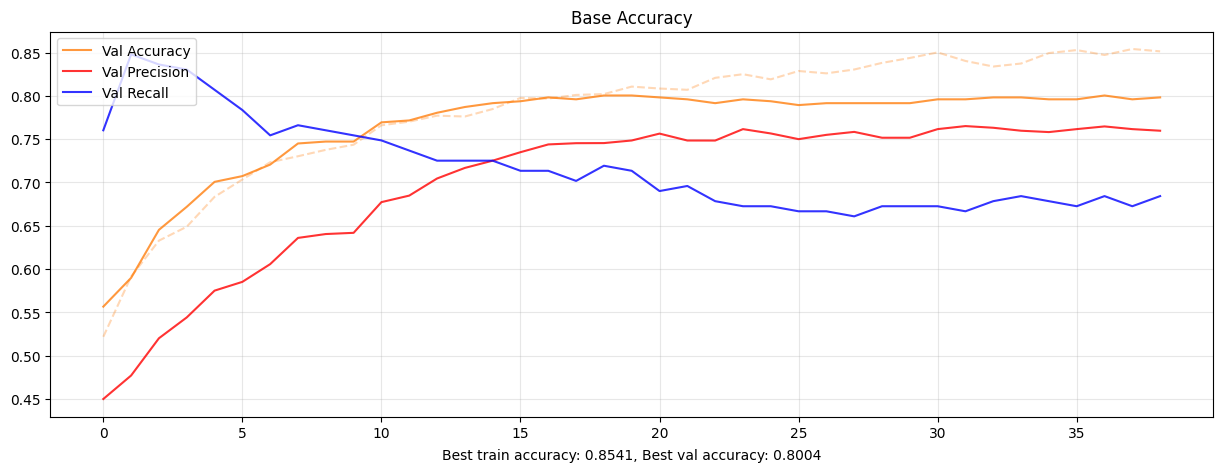

15/15 [==============================] - 1s 12ms/step
0.8049603174603175


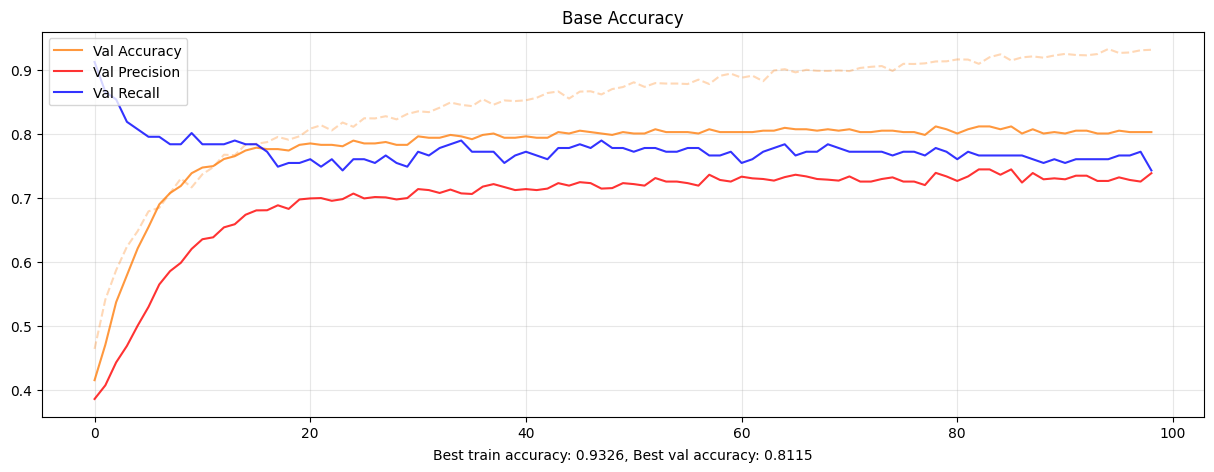

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


for i, history in enumerate(histories):
  predictions = models[i].predict(preprocess_input(X_val * 255))
  predictions = (predictions > 0.5).astype("int32")
  fpr, tpr, thresholds = roc_curve(y_val, predictions)
  roc_auc = auc(fpr, tpr)
  #print(classification_report(y_val, predictions))
  print(roc_auc)
  plot_history(history, models[i].name)

### Crossvalidation

In [ ]:
# Define the number of folds for cross-validation
num_folds = 4

# Initialize lists to store training histories, scores, and best epochs
histories = []
scores = []
best_epochs = []

# Create a KFold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Loop through each fold
for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(X_train_val, y_train_val)):

  print("Starting training on fold num: {}".format(fold_idx+1))

  # Build a new dropout model for each fold
  k_model = build_model(X_train.shape[1:], neurons=[64], dropout=0.5, batch_normalization=True, learning_rate=5e-5, weight_decay=5e-6, name="Base", augmentation=augmentations[0]),

  # Train the model on the training data for this fold
  histories.append(
      models[0].fit(
        x = preprocess_input(X_train_val[train_idx] * 255),
        y = y_train_val[train_idx],
        batch_size = 64,
        epochs = 200,
        validation_data=(preprocess_input(X_train_val[valid_idx] * 255), y_train_val[valid_idx]),
        callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True, start_from_epoch=10),
          tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')]
      ).history
  )

  # Evaluate the model on the validation data for this fold
  #score = k_model.evaluate(X_train_val.iloc[valid_idx], y_train_val.iloc[valid_idx], verbose=0)
  #scores.append(score[1])

  # Calculate the best epoch for early stopping
  #best_epoch = len(history['loss']) - patience
  #best_epochs.append(best_epoch)

  # Store the training history for this fold
  histories.append(history)

### Fine Tuning

In [15]:
!rm -rf TransferLearningModel

In [16]:
model = models[1]
model.save("TransferLearningModel")
del model

In [30]:
def fine_tune(layers, learning_rate):
  model = tf.keras.models.load_model("TransferLearningModel")

  base_model = model.get_layer('mobilenetv2_1.00_96')

  base_model.trainable = False

  if (layers > 0):
    for i, layer in enumerate(base_model.layers[-layers:]):
      if not isinstance(layer, tfkl.BatchNormalization):
        layer.trainable = True
      print(layer)

  for i in range(len(base_model.layers) - layers):
    if (base_model.layers[i].trainable):
      raise Exception("ERROR IN CONFIGURATION, FROZEN LAYERS ARE TRAINABLE")
  for i in range(len(base_model.layers) - layers, len(base_model.layers)):
    if (not base_model.layers[i].trainable and not isinstance(base_model.layers[i], tfkl.BatchNormalization)):
      raise Exception("ERROR IN CONFIGURATION, UNFROZEN LAYERS ARE NOT TRAINABLE")

  model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

  return model

In [ ]:
histories = []

layers = [4]
learning_rates = [5e-6, 5e-6, 5e-6, 5e-6]

class_weights = [
    {
        0: 1,
        1: 1.5
    },
]

for i, layer in enumerate(layers):
  model = fine_tune(layer, learning_rates[i])
  histories.append(
      model.fit(
        x = preprocess_input(X_train * 255),
        y = y_train,
        class_weight=class_weights[i],
        batch_size = 128,
        epochs = 200,
        validation_data = (preprocess_input(X_val * 255), y_val),
        callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=60, restore_best_weights=True, start_from_epoch=5),
          tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-6, mode='max')
        ]
  ).history)

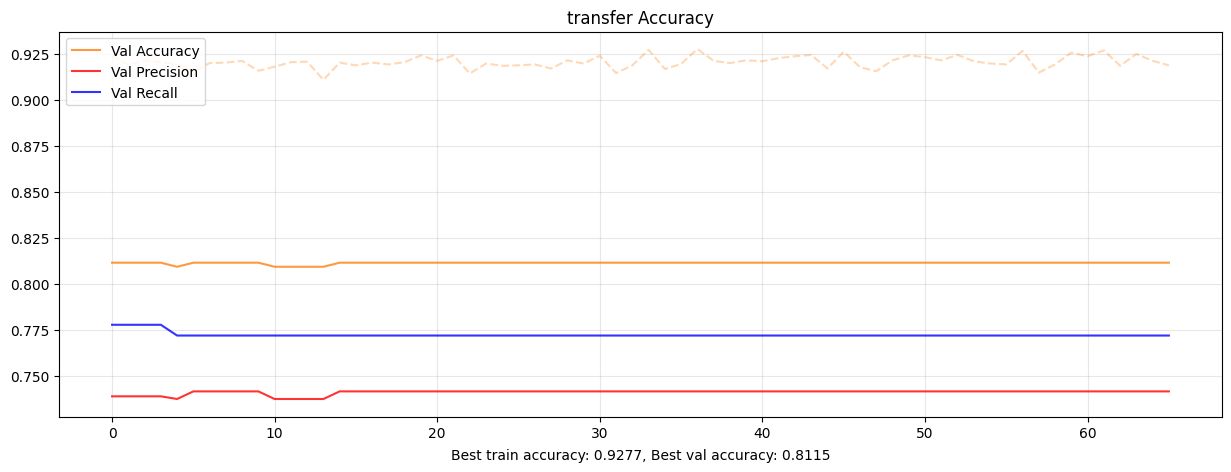

In [32]:
for history in histories:
  plot_history(history, 'transfer')